In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

import matplotlib.pyplot as plt
from diff_music.data.dataset import PianorollDataset

from pathlib import Path

from diff_music.models.midilike_transformer import MidiLikeTransformer
from dataclasses import dataclass

@dataclass
class TrainingParams:
    batch_size: int
    learning_rate: float
    num_epochs: int
    num_workers: int
    generate_steps: int
    save_steps: int
@dataclass
class DataParams:
    max_tokens: int
    path: str

training_params = TrainingParams(
    batch_size=24,
    learning_rate=1e-4,
    num_epochs=100,
    num_workers=10,
    generate_steps=200,
    save_steps=10000,
)

model_params = MidiLikeTransformer.Params(
    hidden_dim=512,
    num_layers=8,
    pitch_range=[21, 109],
    max_len=32*8, # 8 bars
)

data_params = DataParams(
    max_tokens=700,
    path='W:/piano-ai/pop80k_k'
)
ds = PianorollDataset(Path(data_params.path), frames_per_beat=8, length=model_params.max_len)


PianorollDataset initialized with 5509242 segments from 82613 songs


In [3]:
from torch.utils.data import DataLoader
from functools import partial

from diff_music.models.midilike_transformer import collate_fn

max_tokens = data_params.max_tokens
my_collate_fn = partial(collate_fn, max_tokens=max_tokens)
dataloader = DataLoader(ds, batch_size=training_params.batch_size, shuffle=True, drop_last=True, collate_fn=my_collate_fn, num_workers=training_params.num_workers, persistent_workers=training_params.num_workers > 0)

In [4]:
device = torch.device('cuda')

model = MidiLikeTransformer(model_params)
model.to(device)

print('params', sum(p.numel() for p in model.parameters())/1e6, 'M')

optim = torch.optim.Adam(model.parameters(), lr=training_params.learning_rate)

params 25.585626 M


In [5]:
from datetime import datetime
import wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="vqpiano",
    group="midilike-scratch",
    id=datetime.now().strftime("%Y%m%d_%H%M%S"),
    # Track hyperparameters and run metadata
    config={
        "data": data_params,
        "model": model_params,
        "training": training_params,
    },
)
step = 0

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: eri24816 (tanchihpin0517-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
from tqdm import tqdm
import torch_util.wandb

for epoch in range(training_params.num_epochs):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}")
    for token, token_type, pos in pbar:
        model.train()

        token = token.to(device)
        token_type = token_type.to(device)
        pos = pos.to(device)

        loss = model.calculate_loss(token, token_type, pos)
        
        optim.zero_grad()
        loss.total_loss.backward()
        optim.step()

        pbar.set_postfix(loss=loss.total_loss.item(), pitch_loss=loss.pitch_loss.item(), token_type_loss=loss.token_type_loss.item(), pitch_acc=loss.pitch_acc, token_type_acc=loss.token_type_acc)
        wandb.log({
            "loss": loss.total_loss.item(),
            "pitch_loss": loss.pitch_loss.item(),
            "token_type_loss": loss.token_type_loss.item(),
            "pitch_acc": loss.pitch_acc,
            "token_type_acc": loss.token_type_acc,
            "velocity_acc": loss.velocity_acc,
            "velocity_loss": loss.velocity_loss,
        }, step=step)

        if (step % training_params.generate_steps == 0):
            model.eval()
            pr = model.sample_midi(model_params.max_len)
            torch_util.wandb.log_midi_as_audio(pr.to_midi(), 'audio', step, soundfont_path=Path("./ignore/Essential Keys-sforzando-v9.6.sf2"))
            torch_util.wandb.log_image(pr.to_tensor().t().flip(0), 'pr', step)

            torch.cuda.empty_cache()

        
        step += 1
        
        if training_params.save_steps > 0 and step % training_params.save_steps == 0:
            torch.save(model.state_dict(), Path(wandb.run.dir) / f'{step:06d}.pth')

Epoch 0:   0%|          | 187/229551 [01:16<14:59:58,  4.25it/s, loss=2.14, pitch_acc=0.0372, pitch_loss=0.811, token_type_acc=0.841, token_type_loss=0.342]

In [17]:
step

3706

In [18]:

torch_util.wandb.log_midi_as_audio(pr.to_midi(), 'audio', step, soundfont_path=Path("./ignore/Essential Keys-sforzando-v9.6.sf2"))


In [ ]:
model.eval()
pr = model.sample_midi(model_params.max_len)
torch_util.wandb.log_midi_as_audio(pr.to_midi(), 'audio', step, soundfont_path=Path("./ignore/Essential Keys-sforzando-v9.6.sf2"))
torch_util.wandb.log_image(pr.to_tensor().t().flip(0), 'pr', step)


100%|██████████| 256/256 [00:05<00:00, 46.86it/s]


In [8]:
step

548

In [10]:
pr = model.sample_midi(256)

100%|██████████| 256/256 [00:03<00:00, 78.72it/s]


In [ ]:
from torch_util.os import run_command

audio_path = "a.wav"
# pr.to_midi('sample.mid')
f"fluidsynth -R1 -F {audio_path} ./ignore/Essential Keys-sforzando-v9.6.sf2 sample.mid"

'fluidsynth -R1 -F a.wav ./ignore/Essential Keys-sforzando-v9.6.sf2 sample.mid'

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch

import matplotlib.pyplot as plt
from diff_music.data.dataset import PianorollDataset

from pathlib import Path

from diff_music.models.midilike_transformer import MidiLikeTransformer
from dataclasses import dataclass

@dataclass
class TrainingParams:
    batch_size: int
    learning_rate: float
    num_epochs: int
    num_workers: int
    generate_steps: int
    save_steps: int
@dataclass
class DataParams:
    max_tokens: int
    path: str

training_params = TrainingParams(
    batch_size=24,
    learning_rate=1e-4,
    num_epochs=100,
    num_workers=10,
    generate_steps=200,
    save_steps=10000,
)

model_params = MidiLikeTransformer.Params(
    hidden_dim=512,
    num_layers=8,
    pitch_range=[21, 109],
    max_len=32*8, # 8 bars
)

data_params = DataParams(
    max_tokens=700,
    path='W:/piano-ai/pop80k_k'
)
ds = PianorollDataset(Path(data_params.path), frames_per_beat=8, length=model_params.max_len)


PianorollDataset initialized with 5509242 segments from 82613 songs


In [ ]:
from torch.utils.data import DataLoader
from functools import partial

from diff_music.models.midilike_transformer import collate_fn

max_tokens = data_params.max_tokens
my_collate_fn = partial(collate_fn, max_tokens=max_tokens)
dataloader = DataLoader(ds, batch_size=training_params.batch_size, shuffle=True, drop_last=True, collate_fn=my_collate_fn, num_workers=training_params.num_workers, persistent_workers=training_params.num_workers > 0)

In [ ]:
device = torch.device('cuda')

model = MidiLikeTransformer(model_params)
model.to(device)

print('params', sum(p.numel() for p in model.parameters())/1e6, 'M')

optim = torch.optim.Adam(model.parameters(), lr=training_params.learning_rate)

params 25.52009 M


In [ ]:
from datetime import datetime
import wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="vqpiano",
    group="midilike-scratch",
    id=datetime.now().strftime("%Y%m%d_%H%M%S"),
    # Track hyperparameters and run metadata
    config={
        "data": data_params,
        "model": model_params,
        "training": training_params,
    },
)
step = 0

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: eri24816 (tanchihpin0517-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [21]:
from tqdm import tqdm
import torch_util.wandb

for epoch in range(training_params.num_epochs):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}")
    for token, token_type, pos in pbar:
        model.train()

        token = token.to(device)
        token_type = token_type.to(device)
        pos = pos.to(device)

        loss = model.calculate_loss(token, token_type, pos)
        
        optim.zero_grad()
        loss.total_loss.backward()
        optim.step()

        pbar.set_postfix(loss=loss.total_loss.item(), pitch_loss=loss.pitch_loss.item(), token_type_loss=loss.token_type_loss.item(), pitch_acc=loss.pitch_acc, token_type_acc=loss.token_type_acc)
        wandb.log({
            "loss": loss.total_loss.item(),
            "pitch_loss": loss.pitch_loss.item(),
            "token_type_loss": loss.token_type_loss.item(),
            "pitch_acc": loss.pitch_acc,
            "token_type_acc": loss.token_type_acc,
        }, step=step)

        if (step % training_params.generate_steps == 0):
            model.eval()
            pr = model.sample_midi(model_params.max_len)
            torch_util.wandb.log_midi_as_audio(pr.to_midi(), 'audio', step, soundfont_path=Path("./ignore/Essential Keys-sforzando-v9.6.sf2"))
            torch_util.wandb.log_image(pr.to_tensor().t().flip(0), 'pr', step)

            torch.cuda.empty_cache()

        
        step += 1
        
        if training_params.save_steps > 0 and step % training_params.save_steps == 0:
            torch.save(model.state_dict(), Path(wandb.run.dir) / f'{step:06d}.pth')

Epoch 0:   1%|          | 2692/229551 [13:02<18:19:44,  3.44it/s, loss=1.84, pitch_acc=0.122, pitch_loss=0.505, token_type_acc=0.894, token_type_loss=0.244] 


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), Path(wandb.run.dir) / f'{step:06d}.pth')

In [ ]:
pr.to_tensor().shape

torch.Size([128, 88])

In [20]:
model.eval()
pr = model.sample_midi(model_params.max_len)
torch_util.wandb.log_midi_as_audio(pr.to_midi(), 'audio', step, soundfont_path=Path("./ignore/Essential Keys-sforzando-v9.6.sf2"))
torch_util.wandb.log_image(pr.to_tensor().t().flip(0), 'pr', step)


100%|██████████| 256/256 [00:02<00:00, 95.71it/s] 


In [19]:
pr.to_midi('sample.mid')

ticks per beat: 480
max tick: 0
tempo changes: 1
time sig: 0
key sig: 0
markers: 0
lyrics: False
instruments: 1

In [ ]:
token[0]

tensor([[ 0,  0],
        [34, 47],
        [51, 61],
        [53, 63],
        [58, 67],
        [ 0,  0],
        [ 0,  0],
        [ 0,  0],
        [ 0,  0],
        [41, 50],
        [ 0,  0],
        [ 0,  0],
        [46, 58],
        [ 0,  0],
        [ 0,  0],
        [58, 69],
        [ 0,  0],
        [ 0,  0],
        [ 0,  0],
        [ 0,  0],
        [41, 55],
        [ 0,  0],
        [ 0,  0],
        [46, 65],
        [ 0,  0],
        [ 0,  0],
        [58, 58],
        [65, 75],
        [69, 83],
        [ 0,  0],
        [63, 58],
        [ 0,  0],
        [ 0,  0],
        [ 0,  0],
        [41, 53],
        [ 0,  0],
        [ 0,  0],
        [46, 63],
        [ 0,  0],
        [ 0,  0],
        [58, 53],
        [65, 79],
        [ 0,  0],
        [ 0,  0],
        [ 0,  0],
        [ 0,  0],
        [41, 53],
        [ 0,  0],
        [ 0,  0],
        [46, 62],
        [ 0,  0],
        [ 0,  0],
        [34, 49],
        [51, 64],
        [53, 68],
        [5

In [ ]:
pr = model.sample_midi(256)

100%|██████████| 256/256 [00:03<00:00, 78.72it/s]


In [ ]:
token_type[:,:2]

tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]], device='cuda:0')

In [ ]:
a = model.calculate_loss(token[:,:2], token_type[:,:2], pos[:,:2])

tensor([[[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]]], device='

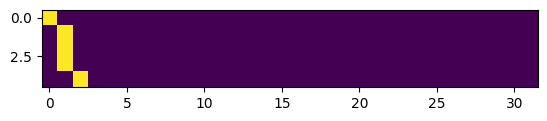

In [ ]:
import einops


pe = one_hot_pe # (len, dim)
pos = torch.tensor([ # (batch_size, len)
    [0,1,2,3,4],
    [0,1,1,1,2]
])
pe_extracted = pe[pos]
plt.imshow(pe_extracted[1])

In [ ]:
pe.shape, pos.shape

(torch.Size([128, 32]), torch.Size([2, 5]))

In [ ]:
from torch.utils.data import DataLoader


dataloader = DataLoader(ds, batch_size=10, collate_fn=lambda x: collate_fn(x, max_tokens=model_params.max_tokens))

In [ ]:
next(iter(dataloader))[0].shape

torch.Size([10, 268, 2])

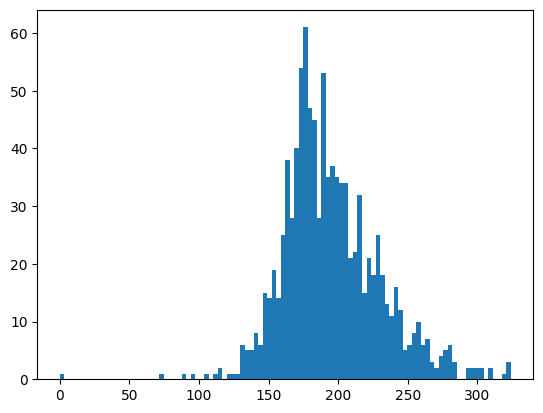

In [ ]:
for token, token_type, pos in dataloader:
    print(token.shape, token_type.shape, pos.shape)
    break

In [ ]:
f"fluidsynth -R1 -F {audio_path} {'./ignore/Essential Keys-sforzando-v9.6.sf2'} {'sample.mid'}"

NameError: name 'audio_path' is not defined

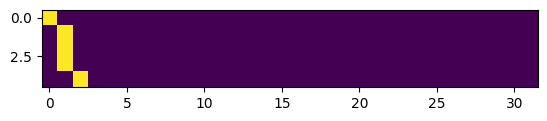

In [47]:
import einops


pe = one_hot_pe # (len, dim)
pos = torch.tensor([ # (batch_size, len)
    [0,1,2,3,4],
    [0,1,1,1,2]
])
pe_extracted = pe[pos]
plt.imshow(pe_extracted[1])

In [49]:
pe.shape, pos.shape

(torch.Size([128, 32]), torch.Size([2, 5]))

In [59]:
from torch.utils.data import DataLoader


dataloader = DataLoader(ds, batch_size=10, collate_fn=lambda x: collate_fn(x, max_tokens=model_params.max_tokens))

In [58]:
next(iter(dataloader))[0].shape

torch.Size([10, 268, 2])

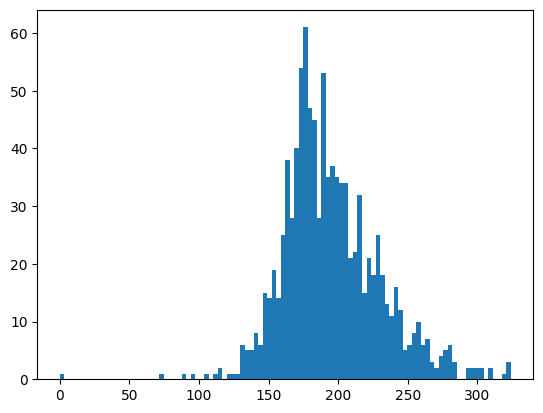

In [36]:
for token, token_type, pos in dataloader:
    print(token.shape, token_type.shape, pos.shape)
    break